In [2]:
import qutip as qt
import QNN as qnn
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.integrate import dblquad

In [3]:
df = pd.read_csv('Params/Function_5/parameters_fold_1.csv')

for i in range(2): 
    df[f'Layer{i}_bx'] = df[[f'Layer{i}_bx', f'Layer{i}_bp']].apply(tuple, axis=1)
    
    df = df.drop(columns=[f'Layer{i}_bp'])
    df = df.rename(columns={f'Layer{i}_bx': f'Layer{i}_bx_bp'})

In [4]:
def state(x, dim, epoch, layer, sublayer, params = df):
    
    psi = qnn.get_vacuum_state_tf(dim)
    psi = tf.matmul(qnn.squeezing_operator(dim, r=100), psi)
    psi = tf.matmul(qnn.displacement_operator(dim, x, 0.0), psi)
    
    if epoch == 0 or layer == 0 or sublayer == 0:
        psi = tf.squeeze(psi, axis=-1)
        psi = psi.numpy()
        return qt.Qobj(psi)
    else:
        N = layer*sublayer
        P = []
        for i in range(1,N+1):
            P.append(params[params.columns[i]][epoch+1])

    ops = [qnn.rotation_operator, qnn.squeezing_operator, qnn.rotation_operator, qnn.displacement_operator, qnn.kerr_operator]
    num_ops = len(ops)
    for i in range(N):
        op = ops[i % num_ops]
        if op == qnn.displacement_operator:
            psi = tf.matmul(op(dim, *P[i]), psi)
        else:
            psi = tf.matmul(op(dim, P[i]), psi)    

    psi = tf.squeeze(psi, axis=-1)
    psi = psi.numpy()
    
    return qt.Qobj(psi)

In [16]:
def wigner_log_negativity(state, L=5, N=100):
    # Create a grid in phase space
    x = np.linspace(-L, L, N)
    p = np.linspace(-L, L, N)
    X, P = np.meshgrid(x, p)
    
    # Compute Wigner function on the grid
    W = np.vectorize(lambda x, p: qt.wigner(state, x, p))(X, P)
    
    # Compute the integral of the absolute value
    dxdp = (2*L/N)**2  # Area element
    integral = np.sum(np.abs(W)) * dxdp
    
    # Compute log negativity
    log_negativity = np.log(integral)
    
    return log_negativity

In [17]:
from matplotlib import cm

def wigner_plot(x, dim = 20, epoch = 0, layer = 0, sublayer = 0):
    psi = state(x, dim, epoch, layer, sublayer)

    xvec = np.linspace(-7, 7, 1000)
    pvec = xvec
    W = qt.wigner(psi, xvec, pvec)

    wmap = qt.wigner_cmap(W)
    nrm = mpl.colors.Normalize(-W.max(), W.max())
    wplot = plt.contourf(xvec, xvec, W, 100, cmap=wmap)  

    da = xvec[1]-xvec[0]
    WLN = wigner_log_negativity(psi)
    print(f'Wigner Log Negativity: {WLN}')

    plt.title("Wigner Colormap")
    cb2 = plt.colorbar(wplot)

    #plt.tight_layout()

    plt.show()

Wigner Log Negativity: 1.0263186299696816


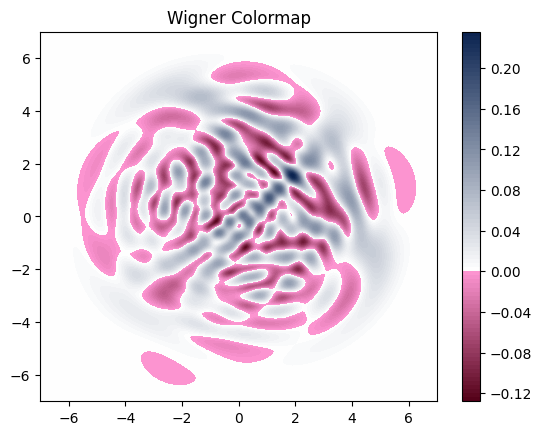

In [18]:
wigner_plot(1.7, epoch=175, layer=1, sublayer=4)